In [39]:
import numpy as np
import pandas as pd
import email
from html.parser import HTMLParser
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from email.parser import BytesParser
from email.policy import default
import csv
import os
import pathlib
import pprint
from os.path import dirname, abspath


In [40]:
# d = dirname(dirname(abspath('__file__')))

In [41]:
#location = f"{d}/case study 3/"

In [42]:
# emails = {"index":[]}
# for path, subdirectories, filelist in os.walk(os.path.join(d,"SpamAssassinMessages")):
#     for f in filelist:
        
#         label = 0 if "ham" in path.lower() else 1
#         with open(os.path.join(path, f), "rb") as fp:
#             msg = BytesParser(policy=default).parse(fp)
#             with open(os.path.join(path, f), "r",encoding= 'utf-8', errors='ignore') as new_f:
#                 msg = email.message_from_file(new_f)
#                 for part in msg.walk():
#                     if part.get_content_type() == 'text/plain':
#                         body = part.get_payload()  # decode
#                 emails["index"].append({
#                     "Subject": msg.get("Subject"),
#                     "From": msg.get("from"),
#                     "Body": body,
#                     "isSpam": label,
#                     "FileID": f
#                 })

# df = pd.DataFrame.from_dict(emails["index"])

In [43]:
# df.to_csv("spam_train.csv", index=False)

In [44]:
df = pd.read_csv("spam_train.csv")

In [45]:
df["isSpam"].value_counts()

0    6954
1    2400
Name: isSpam, dtype: int64

In [46]:
df.isnull().sum()

Subject    26
From        7
Body        8
isSpam      0
FileID      0
dtype: int64

In [47]:
df = df.dropna()

In [48]:
df.reset_index(inplace=True, drop=True)

In [50]:
df["isSpam"].value_counts()

0    6941
1    2379
Name: isSpam, dtype: int64

Build a spam classifier using naive Bayes and clustering. You will have to create your own dataset from the input messages. Be sure to document how you created your dataset.

In [51]:
#remove new lines and such
df = df.replace(r'\n',' ', regex=True)
df = df.replace(r'\t',' ', regex=True)
df = df.replace(r'b\'',' ', regex=True)
df = df.replace(r'b\"',' ', regex=True)

In [54]:
df = df.replace(r'<',' ', regex=True)
df = df.replace(r'>',' ', regex=True)

In [55]:
df["Body"] = df['Body'].str.lower()

In [56]:
df["Subject"] = df['Subject'].str.lower()

In [57]:
df["From"] = df['From'].str.lower()

In [58]:
X = df.drop(["isSpam","FileID"], axis=1).copy()

In [60]:
X["Email"] = X["Subject"] +" "+ X["From"] +" "+ X["Body"]

In [62]:
X = X.drop(columns=["Body","From","Subject"], axis=1)

In [63]:
X.reset_index(inplace=True,drop=True)

In [65]:
from sklearn.feature_extraction.text import CountVectorizer

c_vect = CountVectorizer(stop_words="english")
X = c_vect.fit_transform(X["Email"])

In [66]:
X

<9320x70542 sparse matrix of type '<class 'numpy.int64'>'
	with 1105422 stored elements in Compressed Sparse Row format>

In [64]:
y = df["isSpam"].values
y

array([1, 1, 1, ..., 0, 0, 0])

In [67]:
df_X = pd.DataFrame(X.todense(), columns = c_vect.get_feature_names_out())

In [115]:
X_dense = df_X.copy()
X_agg = df_X.copy()

# Baseline test for Naive Bayes with No Clustering

In [74]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics as mt
import time

skf = StratifiedKFold(random_state=42, n_splits=10,shuffle=True)
nb = MultinomialNB()

acc_scores = []

iter_num=0

for train_indices, test_indices in skf.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    nb.fit(X_train,y_train)  # train object

    y_hat = nb.predict(X_test) # get test set predictions
    print("====Iteration",iter_num," ====")
    acc = mt.accuracy_score(y_test,y_hat)
    acc_scores.append(acc)
    print('Accuracy:', acc)
    iter_num+=1
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")   
print('Mean Accuracy:', np.mean(acc_scores))

====Iteration 0  ====
Accuracy: 0.990343347639485
====Iteration 1  ====
Accuracy: 0.9914163090128756
====Iteration 2  ====
Accuracy: 0.9957081545064378
====Iteration 3  ====
Accuracy: 0.9935622317596566
====Iteration 4  ====
Accuracy: 0.9914163090128756
====Iteration 5  ====
Accuracy: 0.9935622317596566
====Iteration 6  ====
Accuracy: 0.990343347639485
====Iteration 7  ====
Accuracy: 0.9967811158798283
====Iteration 8  ====
Accuracy: 0.9881974248927039
====Iteration 9  ====
Accuracy: 0.9892703862660944
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Mean Accuracy: 0.9920600858369099
CPU times: user 82.3 ms, sys: 22.1 ms, total: 104 ms
Wall time: 105 ms


## Elbow Plot
We see that there are about two clusters using the elbow plot. So will append that to the dataframe for training and testing.

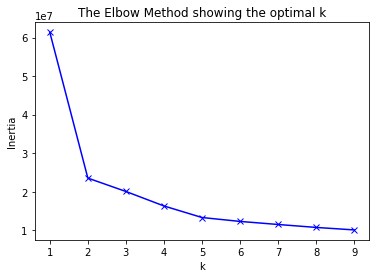

In [116]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# k means determine k
inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    inertia.append(kmeanModel.inertia_)

# Plot the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# K-Means Clustering - 2 Clusters

In [117]:
kmeans = KMeans(n_clusters=2).fit(X)
kmeans.fit(X)
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [118]:
X_dense["Kmeans_Two"] = kmeans.labels_

In [119]:
X_dense["Kmeans_Two"].value_counts()

0    9318
1       2
Name: Kmeans_Two, dtype: int64

In [120]:
from scipy.sparse import csr_matrix
new_X = csr_matrix(X_dense.values)
new_X

<9320x70543 sparse matrix of type '<class 'numpy.int64'>'
	with 1105424 stored elements in Compressed Sparse Row format>

### Adding K-mean cluster labels as a feature and testing the model

In [121]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics as mt
import time

skf = StratifiedKFold(random_state=42, n_splits=10,shuffle=True)
nb = MultinomialNB()

acc_scores = []

iter_num=0

for train_indices, test_indices in skf.split(new_X,y): 
    X_train = new_X[train_indices]
    y_train = y[train_indices]
    
    X_test = new_X[test_indices]
    y_test = y[test_indices]
    nb.fit(X_train,y_train)  # train object

    y_hat = nb.predict(X_test) # get test set predictions
    print("====Iteration",iter_num," ====")
    acc = mt.accuracy_score(y_test,y_hat)
    acc_scores.append(acc)
    print('Accuracy:', acc)
    iter_num+=1
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")   
print('Mean Accuracy:', np.mean(acc_scores))

====Iteration 0  ====
Accuracy: 0.990343347639485
====Iteration 1  ====
Accuracy: 0.9914163090128756
====Iteration 2  ====
Accuracy: 0.9957081545064378
====Iteration 3  ====
Accuracy: 0.9935622317596566
====Iteration 4  ====
Accuracy: 0.9914163090128756
====Iteration 5  ====
Accuracy: 0.9935622317596566
====Iteration 6  ====
Accuracy: 0.990343347639485
====Iteration 7  ====
Accuracy: 0.9967811158798283
====Iteration 8  ====
Accuracy: 0.9881974248927039
====Iteration 9  ====
Accuracy: 0.9892703862660944
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Mean Accuracy: 0.9920600858369099
CPU times: user 63.4 ms, sys: 20 ms, total: 83.4 ms
Wall time: 82.8 ms


# Agglomerative Clustering - 3 Clusters

In [110]:
%%time
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=3)
agg.fit(X.toarray())

AgglomerativeClustering(n_clusters=3)

In [111]:
X_agg["agg"] = agg.labels_

In [112]:
X_agg["agg"].value_counts()

0    9314
2       4
1       2
Name: agg, dtype: int64

In [113]:
X_agg = csr_matrix(X_agg.values)
X_agg

<9320x70543 sparse matrix of type '<class 'numpy.int64'>'
	with 1105428 stored elements in Compressed Sparse Row format>

### Adding Agglomerative cluster labels as a feature and testing the model

In [114]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics as mt
import time

skf = StratifiedKFold(random_state=42, n_splits=10,shuffle=True)
nb = MultinomialNB()

acc_scores = []

iter_num=0

for train_indices, test_indices in skf.split(X_agg,y): 
    X_train = X_agg[train_indices]
    y_train = y[train_indices]
    
    X_test = X_agg[test_indices]
    y_test = y[test_indices]
    nb.fit(X_train,y_train)  # train object

    y_hat = nb.predict(X_test) # get test set predictions
    print("====Iteration",iter_num," ====")
    acc = mt.accuracy_score(y_test,y_hat)
    acc_scores.append(acc)
    print('Accuracy:', acc)
    iter_num+=1
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")   
print('Mean Accuracy:', np.mean(acc_scores))

====Iteration 0  ====
Accuracy: 0.990343347639485
====Iteration 1  ====
Accuracy: 0.9914163090128756
====Iteration 2  ====
Accuracy: 0.9957081545064378
====Iteration 3  ====
Accuracy: 0.9935622317596566
====Iteration 4  ====
Accuracy: 0.9914163090128756
====Iteration 5  ====
Accuracy: 0.9935622317596566
====Iteration 6  ====
Accuracy: 0.990343347639485
====Iteration 7  ====
Accuracy: 0.9967811158798283
====Iteration 8  ====
Accuracy: 0.9881974248927039
====Iteration 9  ====
Accuracy: 0.9892703862660944
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Mean Accuracy: 0.9920600858369099
CPU times: user 77.4 ms, sys: 24.9 ms, total: 102 ms
Wall time: 100 ms
